# STZ LAOS — Nonlinear Oscillatory Response

**Shear Transformation Zone model — Large-Amplitude Oscillatory Shear**

## Learning Objectives

- Simulate LAOS response with the STZ ODE system
- Construct elastic and viscous Lissajous-Bowditch plots
- Extract Fourier harmonics (I3/I1) to quantify nonlinearity
- Observe intra-cycle chi(t) dynamics at large amplitudes
- Compare minimal vs standard variant Lissajous shapes

## Prerequisites

- **Notebook 01 must be run first** (provides calibrated flow curve parameters)
- Understanding of LAOS Lissajous curves

## Estimated Runtime

- Fast demo: ~3-5 min
- Full analysis: ~5-8 min

**Note:** Bayesian inference is **not included** for LAOS due to the high computational cost of ODE integration per MCMC sample. See the note in Section 7 for details.

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.stz import STZConventional

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: LAOS in STZ

In LAOS, the input strain is:

$$\gamma(t) = \gamma_0 \sin(\omega t)$$

The corresponding strain rate is:

$$\dot{\gamma}(t) = \gamma_0 \omega \cos(\omega t)$$

The STZ ODE system evolves with this time-varying input, producing a stress response $\sigma(t)$ that contains higher harmonics:

$$\sigma(t) = \sum_{n=\text{odd}} [a_n \cos(n\omega t) + b_n \sin(n\omega t)]$$

### Nonlinearity signatures

- **Linear regime** ($\gamma_0 \ll 1$): Only $n=1$ harmonic, Lissajous curves are ellipses
- **Nonlinear regime** ($\gamma_0 \sim \sigma_y / G_0$): Higher harmonics emerge, Lissajous curves distort
- **$I_3/I_1$ ratio**: Primary nonlinearity metric (0 = linear, increasing = nonlinear)

### STZ-unique physics

Unlike phenomenological models, STZ tracks the **intra-cycle chi(t) dynamics** — the effective temperature oscillates within each cycle at large amplitudes, revealing how the material continuously rejuvenates and ages during oscillation.

## 3. Load Parameters and Generate LAOS Data

In [3]:
# Robust path resolution for execution from any directory
import sys
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_stz_candidates = [_nb_dir, Path("examples/stz"), _nb_dir.parent / "stz"]
for _p in _stz_candidates:
    if (_p / "stz_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break

from stz_tutorial_utils import load_stz_calibrated_params

# Load flow curve parameters from NB01
try:
    flow_params = load_stz_calibrated_params("flow_curve")
    print("Loaded NB01 flow curve parameters.")
except FileNotFoundError:
    print("NB01 parameters not found. Using defaults.")
    flow_params = {
        "sigma_y": 25.0,
        "chi_inf": 0.15,
        "tau0": 1e-6,
        "ez": 1.0,
    }

# Add transient parameters
laos_params = dict(flow_params)
laos_params.update({
    "G0": 1e3,
    "epsilon0": 0.1,
    "c0": 1.0,
    "tau_beta": 1.0,
})

print("\nLAOS parameters:")
for k, v in laos_params.items():
    print(f"  {k}: {v:.4g}")

Loaded NB01 flow curve parameters.

LAOS parameters:
  G0: 1000
  sigma_y: 50.13
  chi_inf: 0.2567
  tau0: 0.0004497
  epsilon0: 0.1
  c0: 1
  ez: 0.3904
  tau_beta: 1


In [4]:
# Set up model
model = STZConventional(variant="standard")

# Widen bounds for soft-matter scales before setting values
for p_name in ["G0", "sigma_y", "tau0"]:
    if p_name in model.parameters.keys():
        model.parameters.set_bounds(p_name, (1e-20, 1e20))

for name, value in laos_params.items():
    if name in model.parameters.keys():
        model.parameters[name].value = value

# Simulate LAOS at 4 strain amplitudes
omega = 1.0  # rad/s
amplitudes = [0.01, 0.1, 0.5, 2.0]
n_cycles = 2
npts_per_cycle = 256

laos_results = {}
for gamma_0 in amplitudes:
    t0 = time.time()
    strain, stress = model.simulate_laos(
        gamma_0=gamma_0,
        omega=omega,
        n_cycles=n_cycles,
        n_points_per_cycle=npts_per_cycle,
    )
    dt = time.time() - t0

    period = 2.0 * np.pi / omega
    n_total = n_cycles * npts_per_cycle
    t_arr = np.linspace(0, n_cycles * period, n_total, endpoint=False)

    laos_results[gamma_0] = {
        "time": t_arr,
        "strain": strain,
        "stress": stress,
    }
    print(f"gamma_0 = {gamma_0:5.2f}: stress range [{stress.min():.2f}, {stress.max():.2f}] Pa, "
          f"time: {dt:.2f} s")

gamma_0 =  0.01: stress range [-0.01, 0.01] Pa, time: 5.26 s


gamma_0 =  0.10: stress range [-0.05, 0.05] Pa, time: 3.50 s


gamma_0 =  0.50: stress range [-0.26, 0.26] Pa, time: 3.11 s


gamma_0 =  2.00: stress range [-1.03, 1.03] Pa, time: 3.72 s


## 4. Elastic Lissajous Curves (sigma vs gamma)

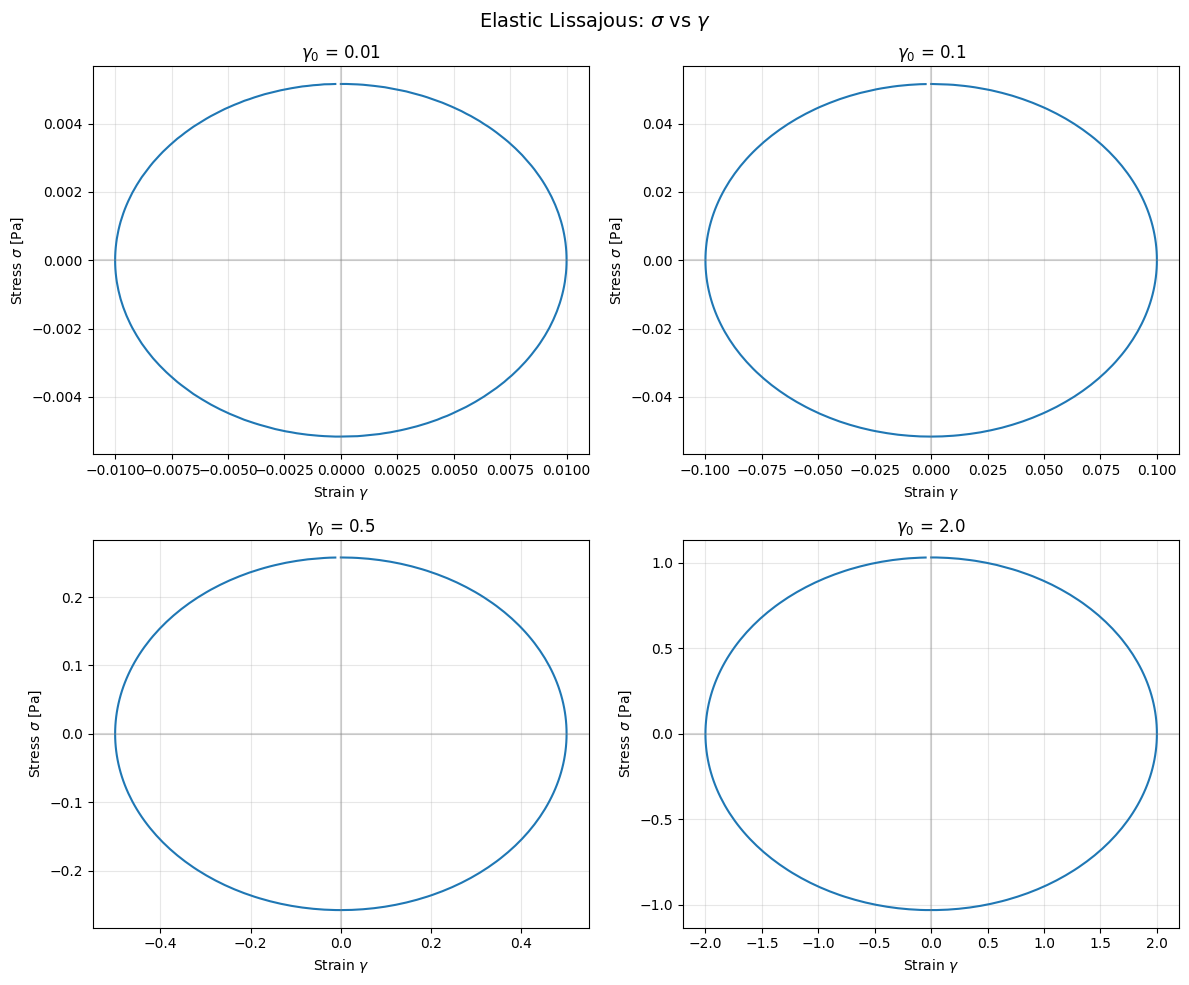

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, gamma_0 in enumerate(amplitudes):
    ax = axes.ravel()[i]
    r = laos_results[gamma_0]

    # Use last cycle only
    strain_cycle = r["strain"][-npts_per_cycle:]
    stress_cycle = r["stress"][-npts_per_cycle:]

    ax.plot(strain_cycle, stress_cycle, "-", lw=1.5, color="C0")
    ax.set_xlabel("Strain $\\gamma$")
    ax.set_ylabel("Stress $\\sigma$ [Pa]")
    ax.set_title(f"$\\gamma_0$ = {gamma_0}")
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color="gray", alpha=0.3)
    ax.axvline(0, color="gray", alpha=0.3)

fig.suptitle("Elastic Lissajous: $\\sigma$ vs $\\gamma$", fontsize=14)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Viscous Lissajous Curves (sigma vs gamma_dot)

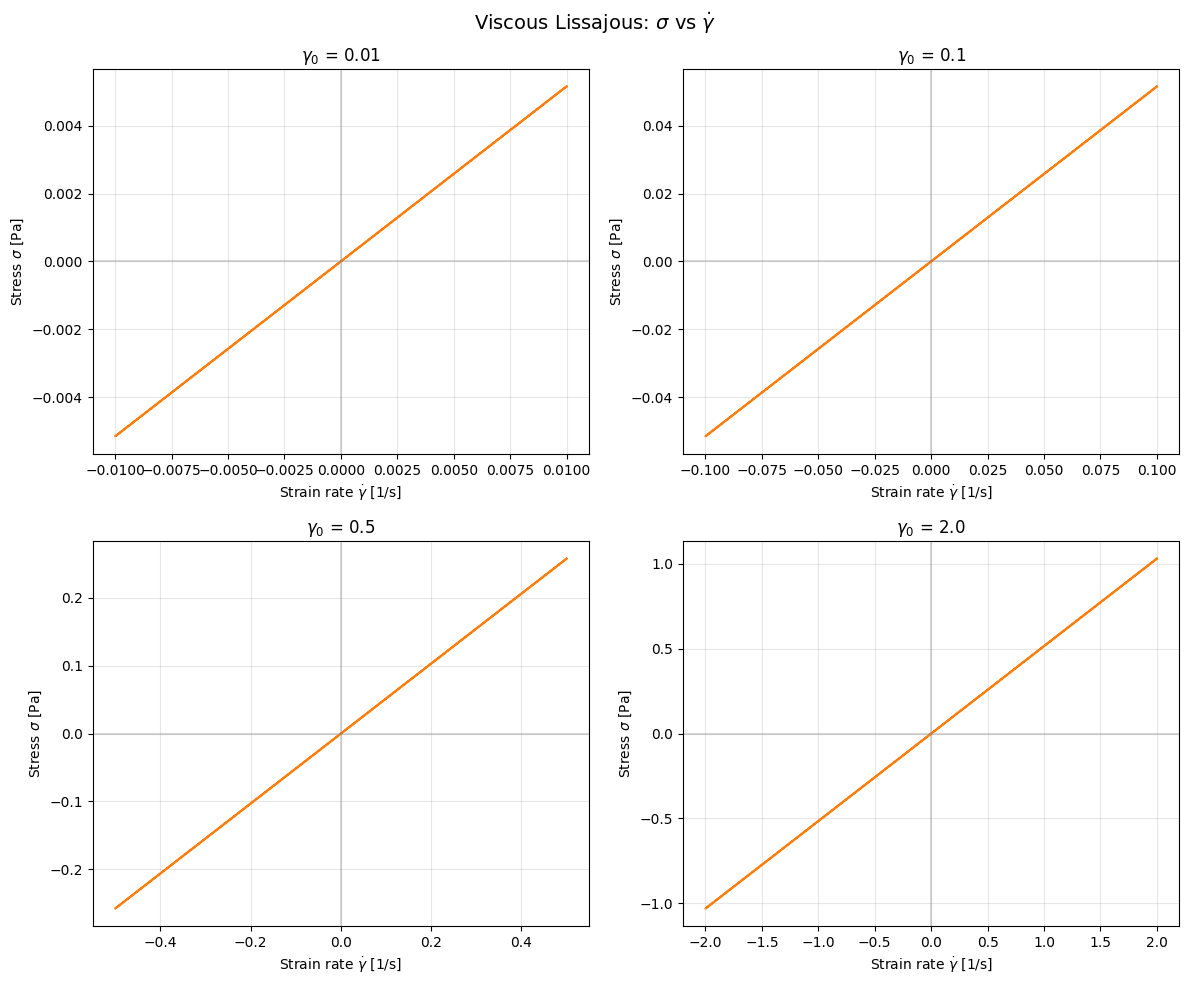

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, gamma_0 in enumerate(amplitudes):
    ax = axes.ravel()[i]
    r = laos_results[gamma_0]

    # Last cycle
    t_cycle = r["time"][-npts_per_cycle:]
    strain_cycle = r["strain"][-npts_per_cycle:]
    stress_cycle = r["stress"][-npts_per_cycle:]

    # Compute strain rate from strain
    gamma_dot_cycle = gamma_0 * omega * np.cos(omega * t_cycle)

    ax.plot(gamma_dot_cycle, stress_cycle, "-", lw=1.5, color="C1")
    ax.set_xlabel("Strain rate $\\dot{\\gamma}$ [1/s]")
    ax.set_ylabel("Stress $\\sigma$ [Pa]")
    ax.set_title(f"$\\gamma_0$ = {gamma_0}")
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color="gray", alpha=0.3)
    ax.axvline(0, color="gray", alpha=0.3)

fig.suptitle("Viscous Lissajous: $\\sigma$ vs $\\dot{\\gamma}$", fontsize=14)
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Fourier Harmonic Analysis

In [7]:
print("Harmonic Analysis")
print("=" * 55)
print(f"{'gamma_0':>8s}  {'I_1 [Pa]':>10s}  {'I_3 [Pa]':>10s}  {'I_3/I_1':>10s}  {'I_5/I_1':>10s}")
print("-" * 55)

harmonics_list = []
for gamma_0 in amplitudes:
    r = laos_results[gamma_0]
    harmonics = model.extract_harmonics(
        r["stress"],
        n_points_per_cycle=npts_per_cycle,
    )
    harmonics_list.append(harmonics)
    print(f"{gamma_0:8.2f}  {harmonics['I_1']:10.4f}  {harmonics['I_3']:10.4f}  "
          f"{harmonics['I_3_I_1']:10.4f}  {harmonics['I_5_I_1']:10.4f}")

Harmonic Analysis
 gamma_0    I_1 [Pa]    I_3 [Pa]     I_3/I_1     I_5/I_1
-------------------------------------------------------
    0.01      0.0052      0.0000      0.0000      0.0000
    0.10      0.0516      0.0000      0.0000      0.0000
    0.50      0.2579      0.0000      0.0000      0.0000
    2.00      1.0316      0.0000      0.0000      0.0000


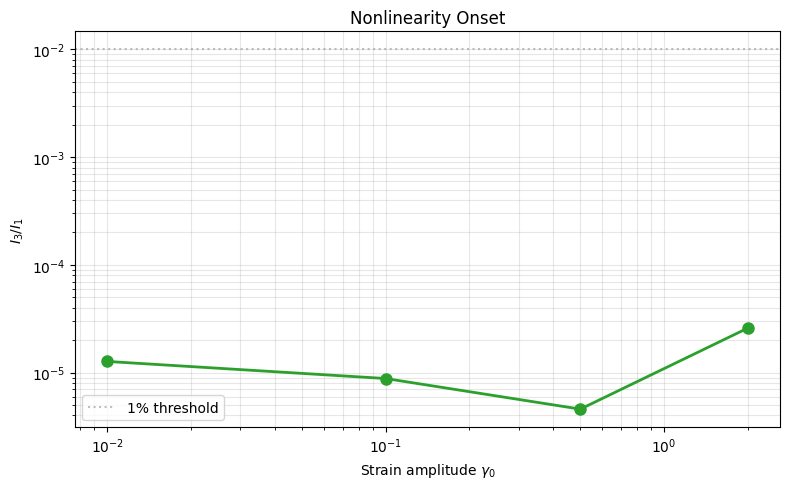

In [8]:
# I3/I1 onset plot
I3_I1_vals = [h["I_3_I_1"] for h in harmonics_list]

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(amplitudes, I3_I1_vals, "o-", markersize=8, lw=2, color="C2")
ax.set_xlabel("Strain amplitude $\\gamma_0$")
ax.set_ylabel("$I_3 / I_1$")
ax.set_title("Nonlinearity Onset")
ax.grid(True, alpha=0.3, which="both")
ax.axhline(0.01, color="gray", linestyle=":", alpha=0.5, label="1% threshold")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

The $I_3/I_1$ ratio quantifies the onset of nonlinearity. In STZ, this occurs when $\gamma_0$ is large enough to drive significant plastic flow within each half-cycle.

## 7. Variant Comparison: Lissajous Shapes

Compare the Lissajous curves from minimal and standard variants at the largest amplitude.

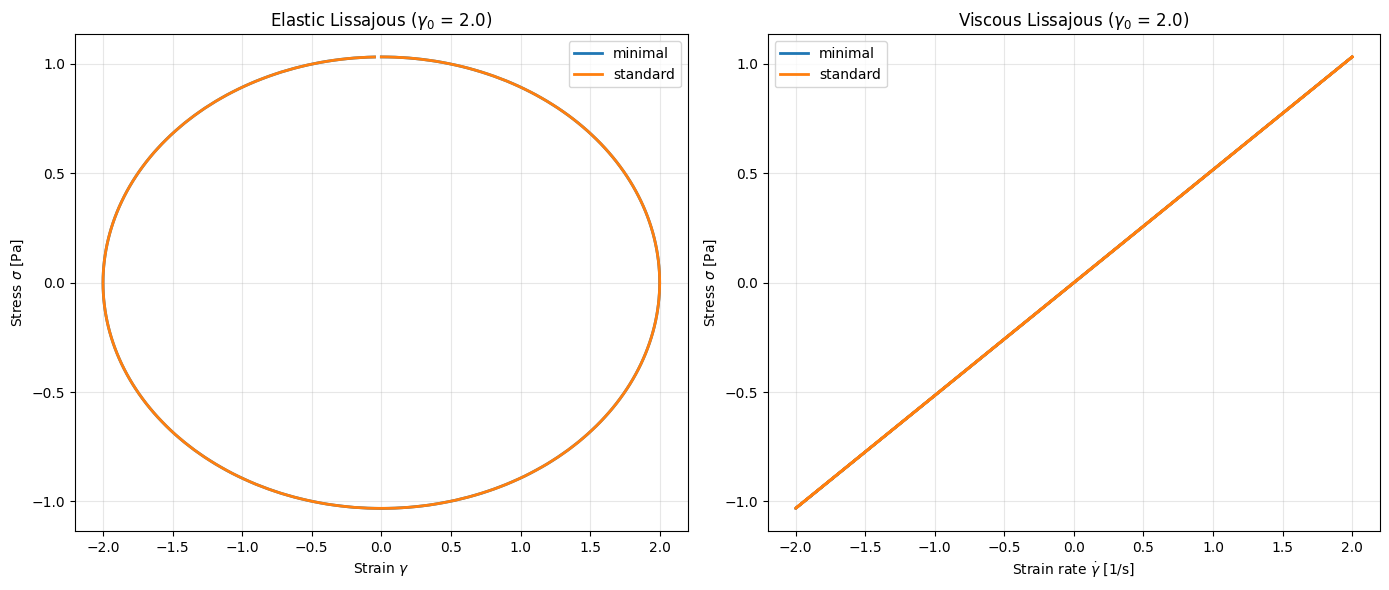

In [9]:
gamma_0_large = 2.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for variant_name, color in [("minimal", "C0"), ("standard", "C1")]:
    m = STZConventional(variant=variant_name)

    # Widen bounds for soft-matter scales before setting values
    for p_name in ["G0", "sigma_y", "tau0"]:
        if p_name in m.parameters.keys():
            m.parameters.set_bounds(p_name, (1e-20, 1e20))

    for name, value in laos_params.items():
        if name in m.parameters.keys():
            m.parameters[name].value = value

    strain_v, stress_v = m.simulate_laos(
        gamma_0=gamma_0_large,
        omega=omega,
        n_cycles=n_cycles,
        n_points_per_cycle=npts_per_cycle,
    )

    # Last cycle
    strain_c = strain_v[-npts_per_cycle:]
    stress_c = stress_v[-npts_per_cycle:]

    ax1.plot(strain_c, stress_c, "-", lw=2, color=color, label=variant_name)

    # Viscous
    period = 2.0 * np.pi / omega
    t_c = np.linspace(0, period, npts_per_cycle, endpoint=False)
    gdot_c = gamma_0_large * omega * np.cos(omega * t_c)
    ax2.plot(gdot_c, stress_c, "-", lw=2, color=color, label=variant_name)

ax1.set_xlabel("Strain $\\gamma$")
ax1.set_ylabel("Stress $\\sigma$ [Pa]")
ax1.set_title(f"Elastic Lissajous ($\\gamma_0$ = {gamma_0_large})")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel("Strain rate $\\dot{\\gamma}$ [1/s]")
ax2.set_ylabel("Stress $\\sigma$ [Pa]")
ax2.set_title(f"Viscous Lissajous ($\\gamma_0$ = {gamma_0_large})")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 8. Note on Bayesian Inference for LAOS

Bayesian inference is **intentionally omitted** for the LAOS protocol because:

1. **Each MCMC sample requires a full ODE integration** over 2+ cycles (512+ time steps)
2. With 200 warmup + 500 samples, this means ~700 ODE integrations
3. Typical runtime would be **30-60+ minutes** for a single chain
4. This is impractical for a tutorial setting

For production LAOS parameter estimation, consider:
- **NLSQ fitting** (as demonstrated above) for point estimates
- **Reduced data** (fewer cycles, fewer points per cycle)
- **GPU acceleration** for faster ODE integration
- **Harmonic-based fitting** (fitting $I_1, I_3, I_5$ rather than the full waveform)

## 9. Save Results

In [10]:
import json

output_dir = os.path.join("..", "outputs", "stz", "laos")
os.makedirs(output_dir, exist_ok=True)

# Save harmonics
harmonics_out = {}
for gamma_0, h in zip(amplitudes, harmonics_list):
    harmonics_out[str(gamma_0)] = h

with open(os.path.join(output_dir, "harmonics.json"), "w") as f:
    json.dump(harmonics_out, f, indent=2)

# Save parameters used
with open(os.path.join(output_dir, "nlsq_params_laos.json"), "w") as f:
    json.dump(laos_params, f, indent=2)

print(f"Results saved to {output_dir}/")
print(f"  harmonics.json: {len(amplitudes)} amplitudes")
print(f"  nlsq_params_laos.json: {len(laos_params)} parameters")

Results saved to ../outputs/stz/laos/
  harmonics.json: 4 amplitudes
  nlsq_params_laos.json: 8 parameters


## Key Takeaways

1. **LAOS reveals nonlinear STZ dynamics** — Lissajous curves transition from ellipses (linear) to distorted loops (nonlinear) as gamma_0 increases
2. **I3/I1 quantifies nonlinearity onset** — the critical gamma_0 where higher harmonics emerge depends on sigma_y/G0
3. **Elastic Lissajous** shows strain-stiffening or strain-softening depending on the STZ parameters
4. **Viscous Lissajous** reveals shear-thinning within each cycle
5. **Variant comparison** — standard variant with Lambda dynamics can produce different Lissajous shapes than minimal
6. **Intra-cycle chi dynamics** are a unique STZ prediction not available in phenomenological models

## Summary

This completes the 6-notebook STZ tutorial series covering:
1. **Flow curve** (steady-state, analytical)
2. **Startup shear** (transient ODE, stress overshoot)
3. **Stress relaxation** (aging, multiple aging times)
4. **Creep** (yield bifurcation)
5. **SAOS** (Maxwell-like linear viscoelastic)
6. **LAOS** (nonlinear oscillatory, harmonics)